In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math

In [2]:
df = pd.read_csv('./kaggle/city_hour.csv')
df

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [3]:
df.dropna()
dfd = df.loc[ df['City'] == 'Delhi']  #will be using the delhi data first for simplicity
dfd = dfd.loc[dfd['Datetime'] < '2016-01-01 00:00:00']
dfd = dfd.drop(['City','AQI_Bucket','Datetime'], axis=1)
dfd['nxtd_AQI'] = dfd['AQI'].shift(-1)
dfd['nxtd_AQI'] = dfd['AQI'].ffill(limit=200)
dfd
dfd = dfd.dropna()

In [4]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4949 entries, 245187 to 253930
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PM2.5     4949 non-null   float64
 1   PM10      4949 non-null   float64
 2   NO        4949 non-null   float64
 3   NO2       4949 non-null   float64
 4   NOx       4949 non-null   float64
 5   NH3       4949 non-null   float64
 6   CO        4949 non-null   float64
 7   SO2       4949 non-null   float64
 8   O3        4949 non-null   float64
 9   Benzene   4949 non-null   float64
 10  Toluene   4949 non-null   float64
 11  Xylene    4949 non-null   float64
 12  AQI       4949 non-null   float64
 13  nxtd_AQI  4949 non-null   float64
dtypes: float64(14)
memory usage: 580.0 KB


In [5]:

x = dfd.iloc[:, :12].values
y = dfd.iloc[:, 13].values
print(y)

[456. 450. 446. ... 432. 433. 435.]


In [6]:
split = int(dfd.shape[0]* 0.8)
train_x, test_x = x[:split, :], x[split:, :]
train_y, test_y = y[:split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (3959, 12) trainY: (3959,)
testX: (990, 12) testY: (990,)


In [7]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

In [10]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i - window: i+1]#i - window: i + 1
        x_.append(tmp_x)
        y_.append(tmp_y)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    return x_, y_

In [11]:
train_x_slide, train_y_slide = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} ')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape}')


train_x: torch.Size([3956, 3, 12]) train_y: torch.Size([3956, 4]) 
test_x: torch.Size([987, 3, 12]) test_y: torch.Size([987, 4])


In [12]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        
        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out


In [13]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 13
learning_rate = 0.004
num_epochs = 5

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)

modelQ = QRegressionLSTM(num_sensors=12, hidden_units= 11, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))


weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [26]:
for epoch in range(num_epochs):
    loss_Q = []
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)
        sum = 0
        for i in output:
            sum+=i
        print("output",output)
        print(sum)
        print("y",y)

output tensor([18.8541, 19.0058, 18.9840, 18.6083, 18.8635, 18.7637, 18.6382, 18.7603,
        18.7401, 18.7532, 18.8223, 18.9141, 18.6759], grad_fn=<ViewBackward0>)
tensor(244.3834, grad_fn=<AddBackward0>)
y tensor([[456., 450., 446., 475.],
        [450., 446., 475., 480.],
        [446., 475., 480., 484.],
        [475., 480., 484., 488.],
        [480., 484., 488., 494.],
        [484., 488., 494., 501.],
        [488., 494., 501., 548.],
        [494., 501., 548., 554.],
        [501., 548., 554., 558.],
        [548., 554., 558., 562.],
        [554., 558., 562., 550.],
        [558., 562., 550., 540.],
        [562., 550., 540., 529.]])
output tensor([18.8230, 18.9784, 18.7593, 18.8673, 18.9732, 18.9403, 18.5764, 18.8855,
        18.7911, 18.7012, 18.6221, 18.8972, 19.1093], grad_fn=<ViewBackward0>)
tensor(244.9242, grad_fn=<AddBackward0>)
y tensor([[550., 540., 529., 513.],
        [540., 529., 513., 449.],
        [529., 513., 449., 435.],
        [513., 449., 435., 422.],
   

KeyboardInterrupt: 

In [17]:
histQ = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_Q = []
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)
        output = torch.cat([y[:, :3], output.reshape(-1, 1)], axis = 1)
        #label = torch.ones_like(y).to(device)
        #lossQ = criterion(output, label)
        lossQ = criterion(output, y)
        lossQ.backward()
        optimizerQ.step()
        loss_Q.append(lossQ.item()) 
    histQ[epoch] = sum(loss_Q)  
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{sum(loss_Q)}')

[1/5]  LossQ:6898304.947387695
[2/5]  LossQ:6459115.6943359375


KeyboardInterrupt: 

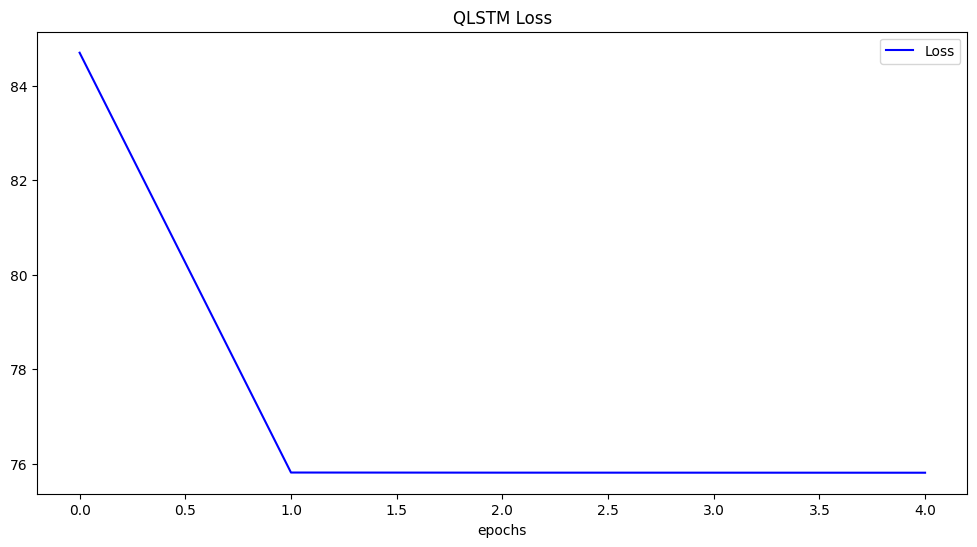

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [14]:
pred_y_train = modelQ(train_x_slide.to(device))
pred_y_test = modelQ(test_x_slide.to(device))


In [15]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
y_train_true = y_scaler.inverse_transform(train_y_slide)

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
pred_y_test = pred_y_test.reshape(-1, 1)
y_train_pred = (y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy()))
y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

In [ ]:

plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black')
plt.plot(y_train_pred, color = 'blue')
plt.legend(loc = 'upper right')

In [ ]:
pred_y_train = modelQ(train_x_slide.to(device))
pred_y_test = modelQ(test_x_slide.to(device))
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
y_train_true = y_scaler.inverse_transform(train_y_slide.reshape(-1,4))
pred_y_train = pred_y_train.cpu().detach().numpy()
y_train_pred = y_scaler.inverse_transform(pred_y_train)
y_test_true = y_scaler.inverse_transform(test_y_slide.reshape(-1,4))
pred_y_test = pred_y_test.cpu().detach().numpy()
y_test_pred = y_scaler.inverse_transform(pred_y_test)
print(len(pred_y_train))
print(len(y_train_true))
print(len(y_train_pred))

3956
3956
3956


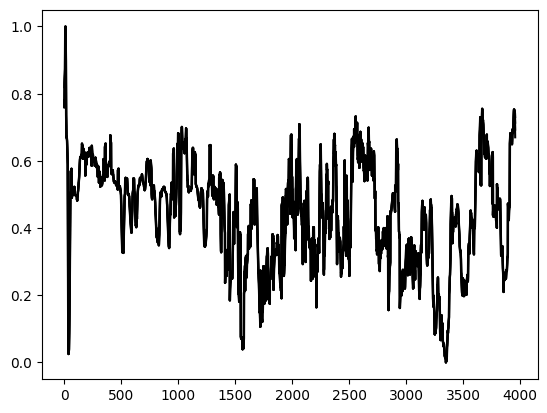

In [ ]:
plt.plot(train_y_slide.reshape(-1,4), color = 'black')

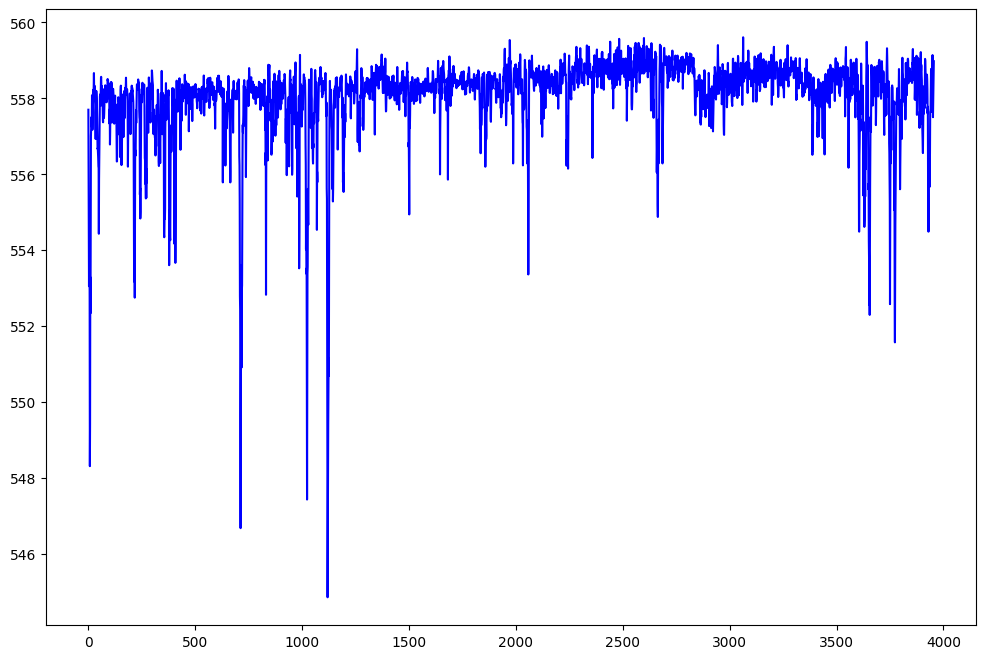

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_pred, color = 'blue')

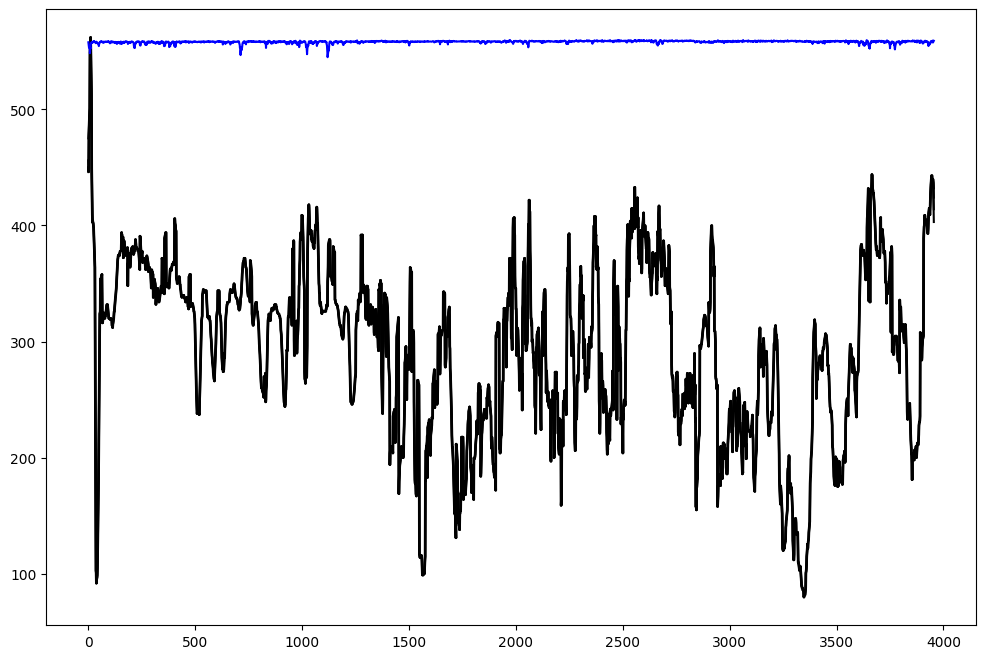

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black')
plt.plot(y_train_pred, color = 'blue')

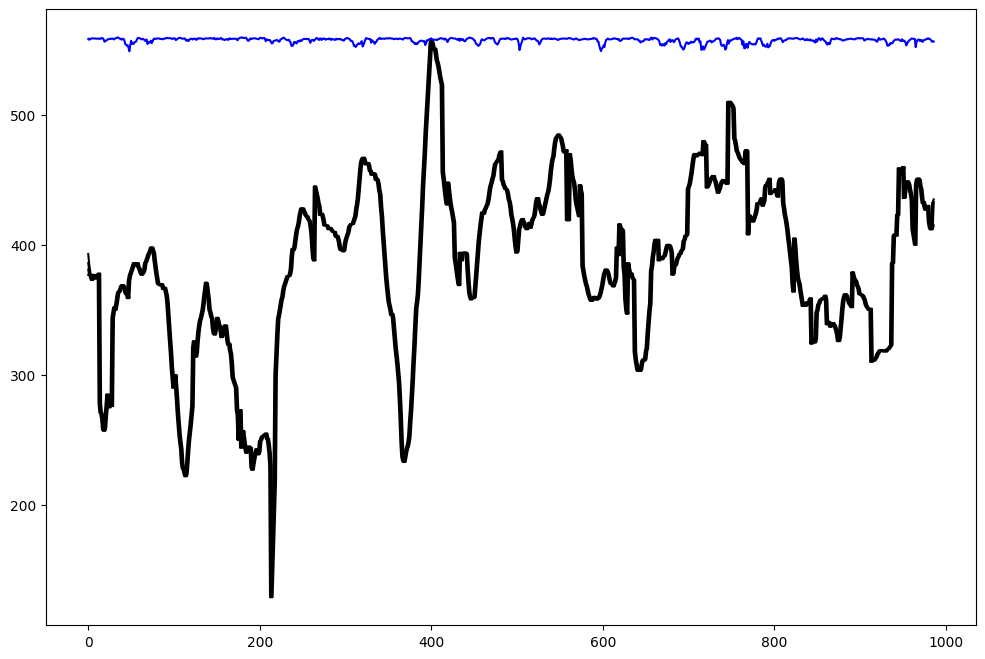

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black')
plt.plot(y_test_pred, color = 'blue')